# **Lennard-Jones gas**

In this code we simulate a set of N particles subjected to Lennard-Jones interactions and confined in a 2D rectangular box. We do this by using the 12-6 Lennard-Jones potential. Then, we solve numerically the Newton's law of motion using Runge-kutta 4. Besides, we use a rustic method of adaptive step by reducing the time step when two particles are *close enough*. The condition for *close enough* is that any of the forces between the particles be greater than or equal to `F0`, which is the Lennard-Jones force between two particles at some distant `R0`. This distance must be choose by the user.

**Credits**
* Juan Andrés Guarín Rojas
* [GitHub](https://github.com/AndresGuarin)

# **Import libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from datetime import datetime

# **1. Computational scheme**

We consider a gas composed of neutral identical particles that interact between each other by the Lennard-Jones potential

$$V_{ij} = 4 \epsilon \left[\left( \frac{\sigma}{r_{ij}} \right)^{12} - \left( \frac{\sigma}{r_{ij}} \right)^{6} \right]$$

which led to a force on the ith particle of
$$ \vec{F}_{i} = 24\epsilon \sum\limits_{j=1}^{N} \left[\frac{2\,\sigma^{12}}{r_{ij}^{13}}-\frac{\sigma^6}{r_{ij}^7}  \right] \hat{r}_{ij}$$ 

where $\vec{r}_{ij}=\vec{r}_i-\vec{r}_j$


For implementing this equations into the code we define the next dimensionless quantities:
$$\bar{t}=\sqrt{\frac{24\epsilon}{m\sigma^2}}t\,,$$
$$ \vec{r}' = \frac{\vec{r}}{\sigma}\,,$$
$$ \bar{r}_{ij} =\frac{r_{ij}}{\sigma}\,. $$

With this definitions the Newton's Law of motion left as
$$ \frac{d^2\vec{r}'_{i}}{d \bar{t}^2}=\sum\limits_{j=1}^{N}\left(\frac{2}{\bar{r}_{ij}^{13}}-\frac{1}{\bar{r}_{ij}^7} \right) \hat{r}'_{ij}\,.$$ 

In [2]:
class LJGas:
    def __init__(self,h=0.05,N=100,Np=2,R0=1.05,h0=0.01,box=[20,10],verbose=False):
        # Dynamic parameters
        self.h = h  # Time lapse between steps
        self.N = N   # Number of steps
        self.Np = Np    # Number of particles

        # Other parameters
        self.h1 = self.h
        self.verbose = verbose

        # Control parameters
        self.R0 = R0                        # Distance of contact
        self.F0 = 2/self.R0**13-1/self.R0**7  # Force of contact
        self.h0 = h0   # Time step for contact events

        # Rectangular box parameters. Note: the box is centered at origin
        self.box = box
        self.lim = [box[0]/2*1.1, box[1]/2*1.1]

    def get_self(self):
        return self

    # Functions
    def Fk(self,X,Y,Vx,Vy):
        # Associated matrixes of distance and force
        I = np.eye(self.Np)
        A, B = np.meshgrid(X,X); dX = A-B
        A, B = np.meshgrid(Y,Y); dY = A-B 
        R = np.sqrt(dX**2+dY**2) + I
        F = 2/R**13-1/R**7
        Ax1 = F*dX/R
        Ay1 = F*dY/R

        # Flatten vectors
        Ax = np.sum(Ax1,axis=0)
        Ay = np.sum(Ay1,axis=0)
        return np.array([Vx, Vy, Ax, Ay])

    def simulate(self,CI):
        LX = np.zeros((self.N+1,self.Np))
        LY = np.zeros((self.N+1,self.Np))
        LVx = np.zeros((self.N+1,self.Np))
        LVy = np.zeros((self.N+1,self.Np))
        self.Lh = np.zeros(self.N+1)

        LX[0] = CI[0]
        LY[0] = CI[1]
        LVx[0] = CI[2]
        LVy[0] = CI[3]
        self.Lh[0] = self.h

        self.LContacts = []
        self.aux = 0

        for i in range(self.N):
            next_val, F1 = self.next_value(LX[i],LY[i],LVx[i],LVy[i])
            LX[i+1] = next_val[0]
            LY[i+1] = next_val[1]
            LVx[i+1] = next_val[2]
            LVy[i+1] = next_val[3]
            
            if np.max(F1) >= self.F0: 
                self.h = self.h0
                if self.aux==0: self.LContacts.append([i])
                self.aux = 1
                if self.verbose: print('here',i,self.h)
                
            else: 
                self.h = self.h1
                if self.aux ==1: 
                    self.LContacts[-1].append(i)
                    if self.verbose: print('here',i,self.h)
                    self.aux = 0
            self.Lh[i+1] = self.h
        
        if self.LContacts != []:
            if len(self.LContacts[-1]) ==1:
                self.LContacts[-1].append(self.N-1)

        return [LX, LY, LVx, LVy]

    def next_value(self,X,Y,Vx,Vy):
        """
            Calculates the next positions and velocities after a time lapse of self.h
            Find the 4 k-values of the Runge-Kutta method (RK4)
            @params
            X,Y,Vx,Vy:
                np.array of the position and velocity of the particles

            @returns
            xf,yf,vxf,vyf
                np.array that contains the final positions and velocities of the particles
        """
        #K1 and calculations
        K1 = self.h*self.Fk(X,Y,Vx,Vy)
        X1 = X + K1[0]/2
        Y1 = Y + K1[1]/2
        Vx1 = Vx + K1[2]/2
        Vy1 = Vy + K1[3]/2

        F1 = np.sqrt(K1[2]**2+K1[3]**2)/self.h #net force

        #K2 and calculations
        K2 = self.h*self.Fk(X1,Y1,Vx1,Vy1)
        X2 = X + K2[0]/2
        Y2 = Y + K2[1]/2
        Vx2 = Vx + K2[2]/2
        Vy2 = Vy + K2[3]/2

        #K3 and calculations
        K3 = self.h*self.Fk(X2,Y2,Vx2,Vy2)
        X3 = X + K3[0]
        Y3 = Y + K3[1]
        Vx3 = Vx + K3[2]
        Vy3 = Vy + K3[3]

        #K4 and calculating final positions
        K4 = self.h*self.Fk(X3,Y3,Vx3,Vy3)
        Xf = X + 1/6*(K1[0] + 2*K2[0] + 2*K3[0] + K4[0])
        Yf = Y + 1/6*(K1[1] + 2*K2[1] + 2*K3[1] + K4[1])
        Vxf = Vx + 1/6*(K1[2] + 2*K2[2] + 2*K3[2] + K4[2])
        Vyf = Vy + 1/6*(K1[3] + 2*K2[3] + 2*K3[3] + K4[3])

        # Reflection at the walls of the box
        ii = Xf>self.box[0]/2    # Right wall
        jj = Xf<-self.box[0]/2   # Left wall
        kk = Yf>self.box[1]/2    # Top wall
        ll = Yf<-self.box[1]/2   # Bottom wall
        
        if np.sum(ii) != 0:     # Bouncing off the right wall
            Xf += ii*(self.box[0]-2*Xf); Vxf += ii*(-Vxf-Vx)
        
        if np.sum(jj) != 0:     # Bouncing off the left wall
            Xf += jj*(-self.box[0]-2*Xf); Vxf += jj*(-Vxf-Vx)
        
        if np.sum(kk) != 0:     # Bouncing off the top wall
            Yf += kk*(self.box[1]-2*Yf); Vyf += kk*(-Vyf-Vy)
        
        if np.sum(ll) != 0:     # Bouncing off the bottom wall
            Yf += ll*(-self.box[1]-2*Yf); Vyf += ll*(-Vyf-Vy)
        
        return np.array([Xf, Yf, Vxf, Vyf]), F1

    def get_net_force(self,s):
        LF = np.zeros((self.N+1,self.Np))
        for i in range(self.N+1):
            X = s[0][i,:]
            Y = s[1][i,:]
            I = np.eye(self.Np)
            A, B = np.meshgrid(X,X); dX = A-B
            A, B = np.meshgrid(Y,Y); dY = A-B 
            R = np.sqrt(dX**2+dY**2) + I
            F = 2/R**13-1/R**7
            LF[i] = np.sum(F,axis=0)

        return LF

    def get_Energy(self,s):
        Ek = np.zeros(self.N+1)
        V = np.zeros(self.N+1)
        for i in range(self.N+1):
            X = s[0][i,:]
            Y = s[1][i,:]
            Vx = s[2][i,:]
            Vy = s[3][i,:]
            I = np.eye(self.Np)
            A, B = np.meshgrid(X,X); dX = A-B
            A, B = np.meshgrid(Y,Y); dY = A-B 
            R = np.sqrt(dX**2+dY**2) + I
            Vi = 1/(6*R**12)-1/(6*R**6)
            Eki = 1/2*(Vx**2+Vy**2)
            V[i] = np.sum(Vi)/2
            Ek[i] = np.sum(Eki)

        return [Ek,V,Ek+V]

In [3]:
# Animation functions

def get_uniform(self,M,amp=1):
    """
    @params 
        M :  np.array of data of the motion as LX, LY, LVx, and LVy. 
             It can be for example s[0], s[1], time
    """
    if self.LContacts != []:
        slice_step = int(self.h/self.h0)*amp
        i0 = self.LContacts[0][0]
        Ls = [M[:i0]]
        for k in range(len(self.LContacts)-1):
            i,j = self.LContacts[k]
            i1,j1 = self.LContacts[k+1]
            Ls.append(M[i:j:slice_step])
            Ls.append(M[j:i1])
        i1,j1 = self.LContacts[-1]
        Ls.append(M[i1:j1:slice_step])
        Ls.append(M[j1:])
        s1 = np.concatenate(Ls)
    else:
        s1 = M
    return s1
def animate_path(self,s,duration=5,kind=0,save=False,name=None,verbose=True,
                 plot_params=['-b','or',0.5,5,0.5],amp=1,length=8,interval=40):
    """
    Animates the positions of the particles of the system.

    @params:
        self : self object. It contains the data of LJGas.solver.particles object.
        s : array-like. It contains the positions and velocities of the particles.
        duration : float. Time in seconds of the simulation.
        kind : int. If it is 0, then we plot lines and point. If it is 1, we plot
            only lines
        save : bool. If it is true the animation is saved in pc.
        name : str. If save is true, then this is the name of the saved video.
            It includes the extension of the video (e.g.: .mp4)
        verbose : bool. If it is true, we show the labels of time and iteration.
        plot_params : list. It contains [fmt1, fmt2, lw1, ms1, alpha1].
        amp : 1. float. It is associated to a parameter of get_uniform function.
        length : float. It is the length of the figure.
        interval : float. Interval in miliseconds between each frame in the 
            animation.
    """
    def get_uniform(self,M,amp=1):
        """
        @params 
            M :  np.array of data of the motion as LX, LY, LVx, and LVy. 
                It can be for example s[0], s[1], time
        """
        if self.LContacts != []:
            slice_step = int(self.h/self.h0)*amp
            i0 = self.LContacts[0][0]
            Ls = [M[:i0]]
            for k in range(len(self.LContacts)-1):
                i,j = self.LContacts[k]
                i1,j1 = self.LContacts[k+1]
                Ls.append(M[i:j:slice_step])
                Ls.append(M[j:i1])
            i1,j1 = self.LContacts[-1]
            Ls.append(M[i1:j1:slice_step])
            Ls.append(M[j1:])
            s1 = np.concatenate(Ls)
        else:
            s1 = M
        return s1

    # Time list
    Lh = self.Lh
    time = np.zeros(self.N+1)
    for i in range(self.N):
        time[i+1] = time[i]+Lh[i]

    # Make the steps uniform
    LX1 = get_uniform(self,s[0],amp)
    LY1 = get_uniform(self,s[1],amp)
    time1 = get_uniform(self,time,amp)
    
    # Plot parameters
    fmt1 = plot_params[0]
    fmt2 = plot_params[1]
    lw1 = plot_params[2]
    ms1 = plot_params[3]
    alpha1 = plot_params[4]

    b0 = self.box[0]/2+self.R0/2; b1 = self.box[1]/2+self.R0/2
    
    #local function for update each frame
    def update(j):    
        ax.clear() # Clear the before plot
        if kind==0:
            for i in range(self.Np):
                plt.plot(LX1[:j,i],LY1[:j,i],fmt1,lw=lw1,alpha=alpha1); ax.plot(LX1[j,i], LY1[j,i], fmt2,ms=ms1) #positions
        if kind==1: 
            for i in range(self.Np): ax.plot(LX1[j,i], LY1[j,i], fmt2,ms=ms1)
        plt.plot(0,0,'o',ms=0, label=r'$n=$'+f'{j}\n'+r'$\overline{t}=$ '+f'{np.round(time1[j],1)}') #legends
        plt.plot([-b0,b0,b0,-b0,-b0],[-b1,-b1,b1,b1,-b1],'-b',lw=2) #box
        if verbose: plt.legend(loc='upper right')
    
    # Create figure and axis
    heigth = b1/b0*length
    fig = plt.figure(figsize=(length*1.1,heigth))
    ax = fig.gca()
    
    # Set the steps of the animation
    local_time = interval/100   # Empirical time in seconds that matplotlib.pyplot lasts for each plot of the animation
    Nf = LX1.shape[0]
    dj = int(Nf*local_time/duration)
    
    # Animate the movement
    anim = animation.FuncAnimation(fig,update,range(1,Nf,dj), repeat=False, interval=interval)
    if save: anim.save(name,writer='ffmpeg')
    return anim
    #plt.show(ani)

In [4]:
# Visualization functions

def moving_mean(t,X,w=4,kind=0):
    """
    @params
        t : array-like. It is the data of the x-axis, which will not be averaged.
It can be for example the time data
        X : array-like. It is the data that will be averaged.
        w : int. It is the size of the window where we will make the average.
        kind : int. It is the kind of moving mean
                0 : centered mean
                1 : left-centered mean
                2 : right-centered mean
    """
    
    if kind == 0:
        w1 = int((w-1)/2); w2 = w-w1-1; 
        Xmean = np.zeros(len(X))
        #Xmean = np.zeros(len(X)-w1-w2)
        #for i in range(w1,len(X)-w2): Xmean[i-w1] = np.mean(X[i-w1:i+w2+1])
        for i in range(len(X)):
            if i-w <0: w1 = 0; w2 = w
            elif i+w+1 > len(X): w2=-i-2; w1 = w-w2-1
            else: w1 = int((w-1)/2); w2 = w-w1-1
            Xmean[i] = np.mean(X[i-w1:i+w2+1])
        #t1 = t[w1:-w2]
        t1 = t
    return t1, Xmean

# **2. Simulation of the colision of two particles**

In [6]:
# Choose parameters 
h = 0.05; N = 120; Np = 2; R0 = 1.05; h0 = 0.01

# Set intial conditions
X0 = np.array([0,2])
Y0 = np.array([0,0])
Vx0 = np.array([0.5,0])
Vy0 = np.array([0,0])

sim = LJGas(h,N,Np,R0,h0,verbose=False,box=[10,5])
s = sim.simulate([X0,Y0,Vx0,Vy0])

self1 = sim.get_self()
Lh = self1.Lh
time = np.zeros(N+1)
for i in range(N):
    time[i+1] = time[i]+Lh[i]

In [7]:
#plt.plot(time)
Lh[36]

0.01

In [8]:
%matplotlib inline

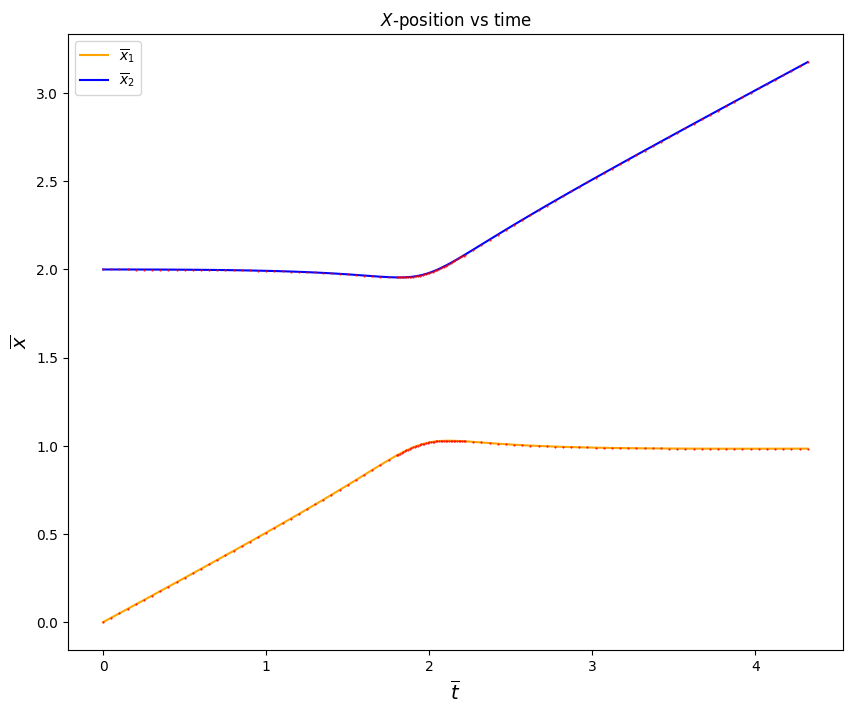

In [9]:
X1 = s[0][:,0]
X2 = s[0][:,1]

plt.figure(figsize=(10,8))
plt.title(r'$X$-position vs time')
plt.ylabel(r'$\overline{x}$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time,X1,'-',color='orange',label=r'$\overline{x}_1$') ;plt.plot(time,X1,'o',color='red', ms=0.5)
plt.plot(time,X2,'-b',ms=0.5,label=r'$\overline{x}_2$')        ;plt.plot(time,X2,'o',color='red', ms=0.5)
#plt.ylim(-0.2,4.2)
plt.legend()
plt.savefig('images/2ParticlesGas/x_position.png',dpi=350)
plt.show()

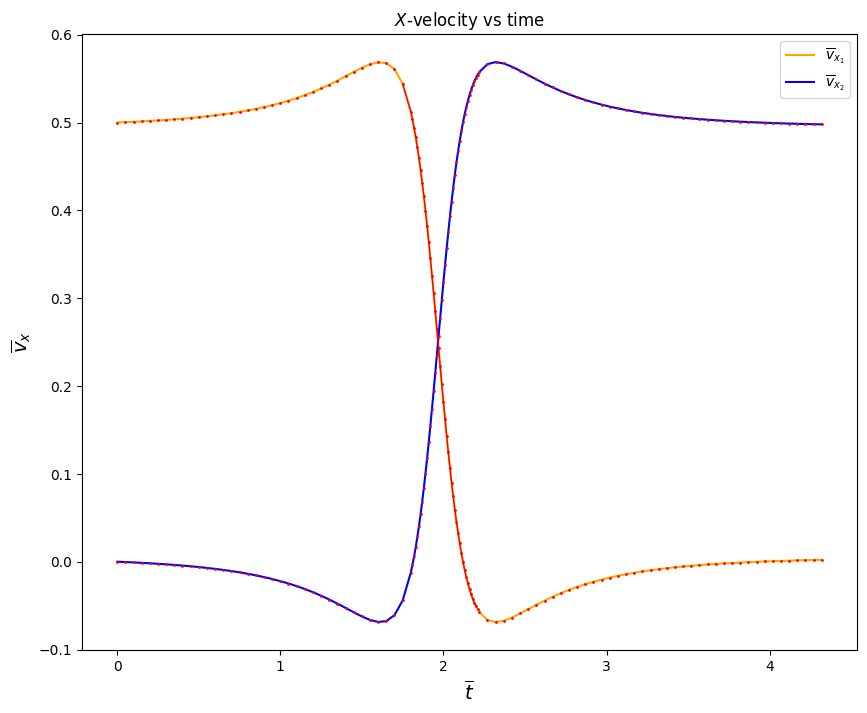

In [10]:
VX1 = s[2][:,0]
VX2 = s[2][:,1]

plt.figure(figsize=(10,8))
plt.title(r'$X$-velocity vs time')
plt.ylabel(r'$\overline{v}_x$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time,VX1,'-',color='orange',label=r'$\overline{v}_{x_1}$') ;plt.plot(time,VX1,'o',color='red', ms=1)
plt.plot(time,VX2,'-b',ms=0.5,label=r'$\overline{v}_{x_2}$')        ;plt.plot(time,VX2,'o',color='red', ms=1)

plt.legend()
plt.plot(time[35:77],VX1[35:77],'-',color='red',lw=1)
plt.savefig('images/2ParticlesGas/x_velocity.png',dpi=350)
#plt.ylim(-0.2,4.2)
plt.show()

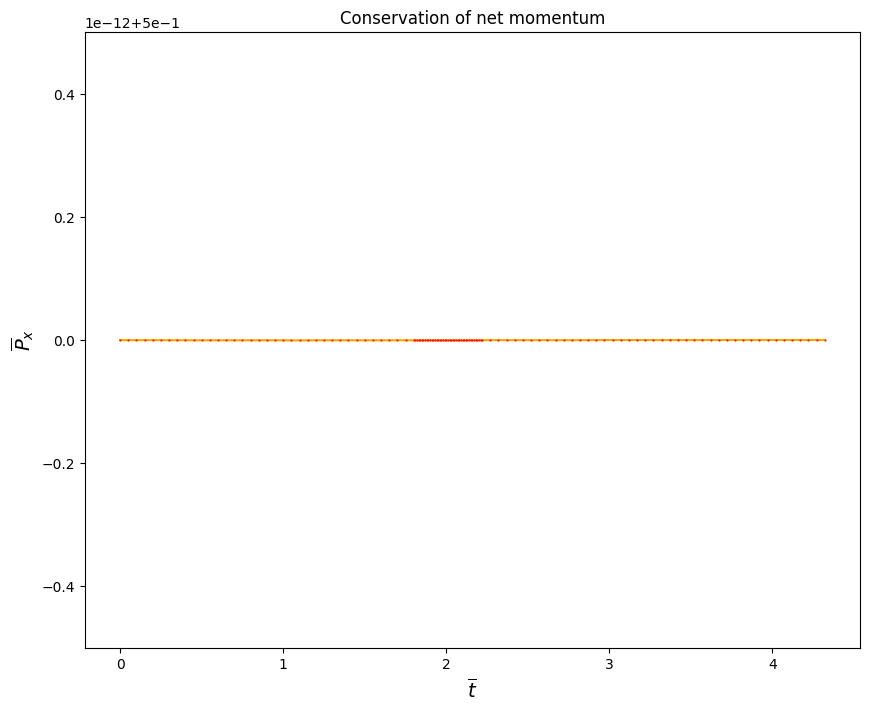

In [11]:
VX1 = s[2][:,0]
VX2 = s[2][:,1]

plt.figure(figsize=(10,8))
plt.title('Conservation of net momentum')
plt.ylabel(r'$\overline{P}_x$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time,VX1+VX2,'-',color='orange') ;plt.plot(time,VX1+VX2,'o',color='red', ms=0.5)
#plt.ylim(-0.2,4.2)
plt.savefig('images/2ParticlesGas/x_net_momentum.png',dpi=350)
plt.show()

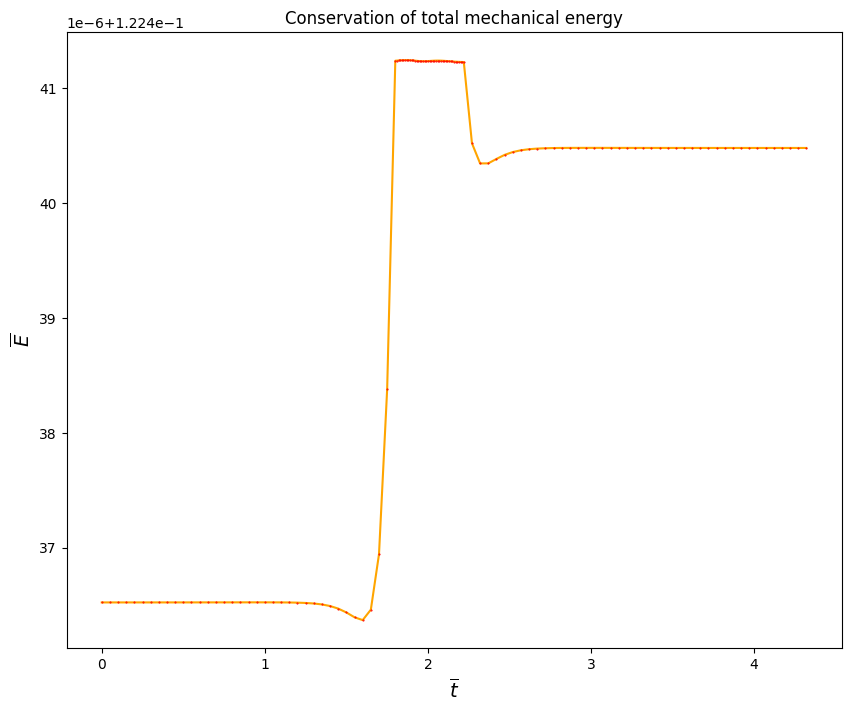

In [12]:
Em = sim.get_Energy(s)[2]

plt.figure(figsize=(10,8))
plt.title('Conservation of total mechanical energy')
plt.ylabel(r'$\overline{E}$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time,Em,'-',color='orange') ;plt.plot(time,Em,'o',color='red', ms=0.5)
plt.savefig('images/2ParticlesGas/net_mechanical_energy.png',dpi=350)
#plt.ylim(-0.2,4.2)
plt.show()

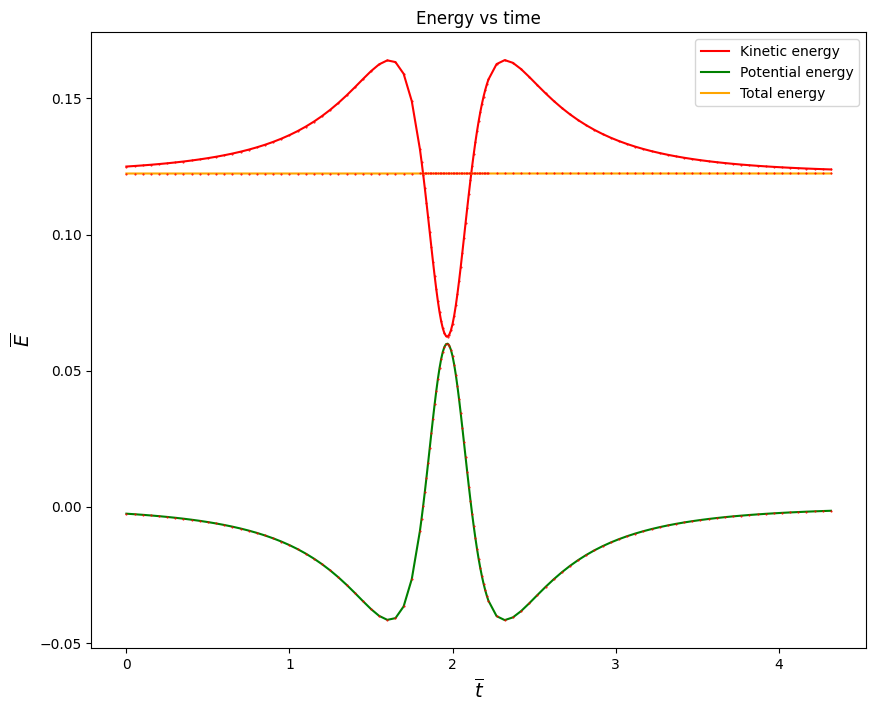

In [13]:
Ek, V, Em  = sim.get_Energy(s)

plt.figure(figsize=(10,8))
plt.title('Energy vs time')
plt.ylabel(r'$\overline{E}$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time, Ek,'-',color='red',label = 'Kinetic energy') ;plt.plot(time, Ek,'o',color='red', ms=0.5)
plt.plot(time, V,'-',color='green',label = 'Potential energy') ;plt.plot(time, V,'o',color='red', ms=0.5)
plt.plot(time, Em,'-',color='orange',label = 'Total energy') ;plt.plot(time, Em,'o',color='red', ms=0.5)
plt.legend()
plt.savefig('images/2ParticlesGas/energy_vs_time.png',dpi=350)
#plt.ylim(-0.2,4.2)
plt.show()

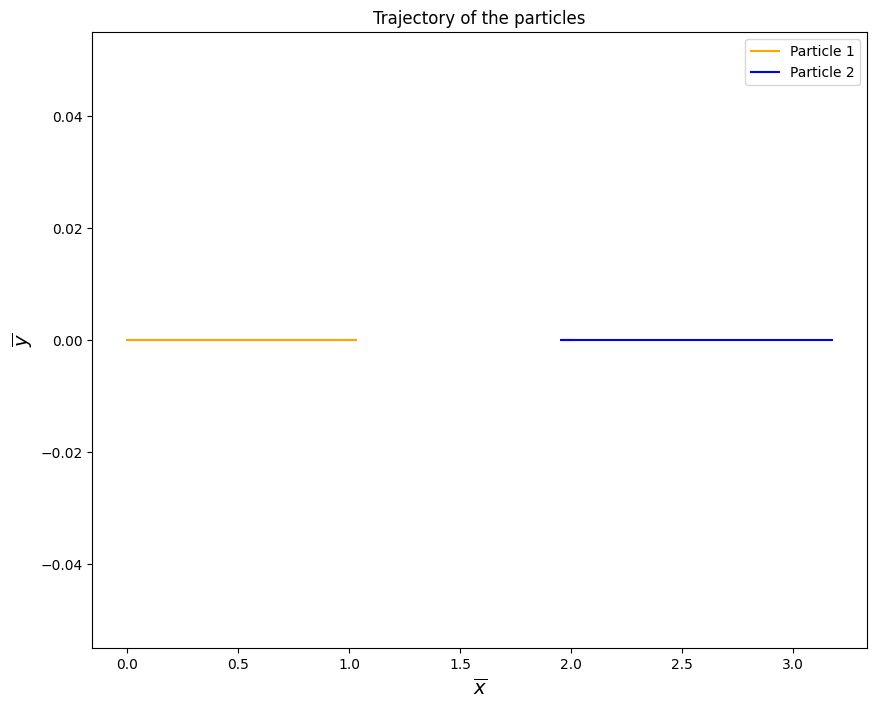

In [14]:
X1 = s[0][:,0]
X2 = s[0][:,1]
Y1 = s[1][:,0]
Y2 = s[1][:,1]

plt.figure(figsize=(10,8))
plt.title(r'Trajectory of the particles')
plt.xlabel(r'$\overline{x}$',fontsize=14)
plt.ylabel(r'$\overline{y}$',fontsize=14)
plt.plot(X1,Y1,'-',color='orange',label='Particle 1') #;plt.plot(X1,Y1, 'o',color='red', ms=0.5)
plt.plot(X2,Y2,'-b',ms=0.5,label='Particle 2')        #;plt.plot(X2,Y2, 'o',color='red', ms=0.5)
#plt.ylim(-0.2,4.2)
plt.legend()
plt.savefig('images/2ParticlesGas/trajectory.png',dpi=350)
plt.show()

In [15]:
%matplotlib inline

In [5]:
%matplotlib auto
%matplotlib auto

Using matplotlib backend: <object object at 0x000001B8F99FB4E0>
Using matplotlib backend: QtAgg


In [17]:
self1.LContacts

[[35, 77]]

In [20]:
#animate_path(self1,s,duration=5,kind=0,save=False,verbose=True,plot_params=['-b','or',1.5,20,2])
#plt.show()

In [21]:
X1 = s[0][:,0]; X2 = s[0][:,1]
Y1 = s[1][:,0]; Y2 = s[1][:,1]
R = np.sqrt((X1-X2)**2+(Y1-Y2)**2)

In [22]:
dX1 = X1[1:]-X1[0:-1]
v_num = dX1/h
VX1 = s[2][:,0]; VY1 = s[3][:,0]
VX2 = s[2][:,1]; VY2 = s[3][:,1]
V1 = np.sqrt(VX1**2+VY1**2)
V2 = np.sqrt(VX2**2+VY2**2)

In [23]:
CR = -(V1[-1]-V2[-1])/(V1[0]-V2[0]) #Coeficient of restitution
CR

0.9913914363569386

In [24]:
aux = V1[0:-1]-v_num
aux[17:57]

array([-9.71477193e-04, -1.07698786e-03, -1.19419484e-03, -1.32386990e-03,
       -1.46644483e-03, -1.62170290e-03, -1.78826766e-03, -1.96275750e-03,
       -2.13838648e-03, -2.30264170e-03, -2.43341621e-03, -2.49256005e-03,
       -2.41515577e-03, -2.09189925e-03, -1.34104416e-03,  1.33136663e-04,
        2.79157315e-03,  7.29072562e-03,  1.43884570e-02,  4.10750573e-01,
        4.03864046e-01,  3.96266026e-01,  3.87925202e-01,  3.78815622e-01,
        3.68918205e-01,  3.58222321e-01,  3.46727362e-01,  3.34444228e-01,
        3.21396621e-01,  3.07622049e-01,  2.93172416e-01,  2.78114104e-01,
        2.62527474e-01,  2.46505726e-01,  2.30153131e-01,  2.13582678e-01,
        1.96913238e-01,  1.80266391e-01,  1.63763093e-01,  1.47520385e-01])

In [25]:
aux[0:20]

array([-0.00019471, -0.00021218, -0.00023146, -0.00025275, -0.0002763 ,
       -0.00030237, -0.00033126, -0.00036332, -0.00039893, -0.00043853,
       -0.0004826 , -0.0005317 , -0.00058644, -0.00064752, -0.00071569,
       -0.00079179, -0.00087674, -0.00097148, -0.00107699, -0.00119419])

# **3. Simulation of 30 particles**

### **Simulation 1**

In [5]:
# Choose parameters 
h = 0.05; N = 4500; R0 = 1.05; h0 = 0.01; box=[20,10]

# Set intial conditions
X0 = np.array([-6,-4,0,-6,-4,0,-6,-4,0,4,4,4,6,6,6])
Y0 = np.array([-4,-4,-4,0,0,0,4,4,4,-4,0,4,-4,0,4])
Vx0 = np.array([0.6,0.4,0.7,0.3,0.5,0.4,0.8,0.9,0.2,0.1,0.3,0.4,0.2,0.6,0.7])
Vy0 = np.array([0,0,0,0,0.2,0,0,0,0,0,0,0,0,0,0])

Np = len(X0)

sim = LJGas(h,N,Np,R0,h0,box,verbose=False)
s = sim.simulate([X0,Y0,Vx0,Vy0])

self1 = sim.get_self()
Lh = self1.Lh
time = np.zeros(N+1)
for i in range(N):
    time[i+1] = time[i]+Lh[i]

### **Simulation 2**

In [6]:
# Choose parameters 
h = 0.05; N = 6000; R0 = 1.05; h0 = 0.01; box=[80,40]

# Set intial conditions
a=30; b=15; c=15
X0 = np.array([ 18.  ,   0.93, -23.51, -36.88, -35.71, -38.75, -16.77,  -1.22,
       -22.28,  -0.99, -18.36, -11.16, -12.55,   7.04,  24.56,  22.67,
        26.82,   4.01,  16.79,  35.79,  39.06,  12.14, -29.22,  20.53,
        24.67, -39.35, -13.38,  10.95,  18.72, -22.11])
Y0 = np.array([-17.91,   6.76,   0.21, -14.83,  11.59,  19.69,  11.14,   4.49,
       -11.12,  -7.14, -12.82,  -7.78,  -9.67,   4.61,   9.84,   3.03,
        11.83,   8.12, -15.22, -11.9 ,  -4.28,  15.86,   0.61,  12.5 ,
         7.18,  17.64,  -7.  ,  -1.03,  -5.99,  13.03])
Vx0 = np.array([ 0.38,  0.19, -0.  , -0.54, -0.65, -0.39,  0.12,  1.18,  0.43,
        0.33, -0.78, -1.3 ,  0.67, -0.57, -0.55, -0.96, -0.72, -0.9 ,
       -0.76, -0.69,  0.33, -1.07,  0.81, -0.45, -1.19, -0.43,  0.32,
        1.12, -1.21,  1.25])
Vy0 = np.array([-1.  , -0.99,  0.26,  0.38,  0.6 ,  1.17,  0.86,  1.06, -0.55,
       -0.39, -0.7 ,  1.09, -0.91,  1.15, -1.01, -0.71,  0.36, -0.02,
       -1.15,  0.4 ,  0.48, -0.38, -1.08,  0.08,  0.43, -0.12,  0.14,
        0.4 , -0.95, -1.19])
Np = len(X0)

sim = LJGas(h,N,Np,R0,h0,box,verbose=False)
s = sim.simulate([X0,Y0,Vx0,Vy0])

self1 = sim.get_self()
Lh = self1.Lh
time = np.zeros(N+1)
for i in range(N):
    time[i+1] = time[i]+Lh[i]

### **Simulation 3**

In [26]:
# Choose parameters 
h = 0.05; N = 16000; R0 = 1.05; h0 = 0.01; box=[400,200]

# Set intial conditions
v0 = 2
Np = 25

np.random.seed(174489)
#X0 = np.random.uniform(-box[0]*0.45, box[0]*0.45, 30)
#Y0 = np.random.uniform(-box[1]*0.45, box[1]*0.45, 30)
#Vx0 = np.random.uniform(-v0,v0,30)
#Vy0 = np.random.uniform(-v0,v0,30)

#X0 = np.random.normal(0,box[0]*0.15,30)
#Y0 = np.random.normal(0,box[1]*0.15,30)
#Vx0 = np.random.normal(0,v0,30)
#Vy0 = np.random.normal(0,v0,30)

X0 = np.random.random(Np)*box[0]*0.9 - box[0]*0.9/2
Y0 = np.random.random(Np)*box[1]*0.9 - box[1]*0.9/2
Theta0 = np.random.random(Np)*2*np.pi - np.pi
Vx0 = 2*np.cos(Theta0) + np.random.random(Np)*0.1 - 0.05
Vy0 = 2*np.sin(Theta0) + np.random.random(Np)*0.1 - 0.05

#X0 = Xf; Y0 = Yf; Vx0 = Vxf; Vy0 = Vyf
Np = len(X0)

sim = LJGas(h,N,Np,R0,h0,box,verbose=False)
s = sim.simulate([X0,Y0,Vx0,Vy0])

self1 = sim.get_self()
Lh = self1.Lh
time = np.zeros(N+1)
for i in range(N):
    time[i+1] = time[i]+Lh[i]

In [27]:
#np.round(Vx0,2), np.round(Vy0,2)
np.mean(Vx0), np.mean(Vy0)

(-0.02563842397625466, -0.03089043182458476)

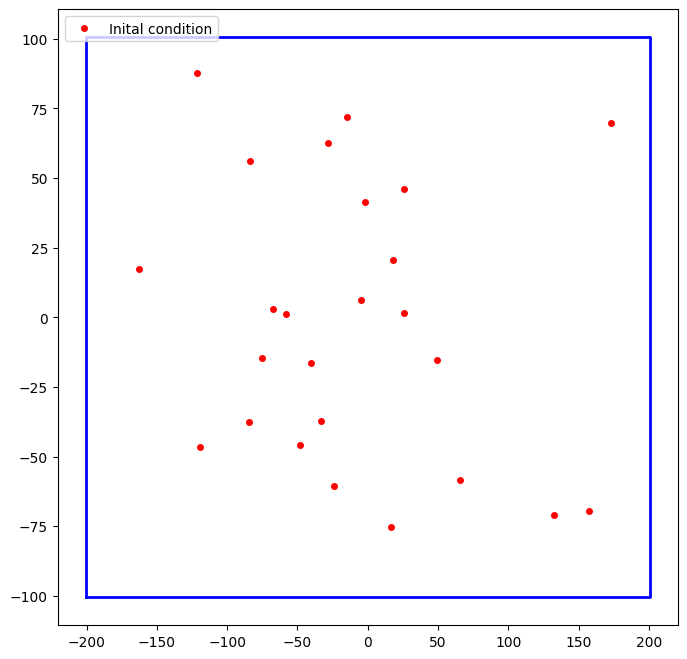

In [28]:
%matplotlib inline

Xf = s[0][-1,:]; Yf = s[1][-1,:]; Vxf = s[2][-1,:]; Vyf = s[3][-1,:]

b0 = box[0]/2 + R0/2; b1 = box[1]/2 + R0/2
plt.plot([-b0,b0,b0,-b0,-b0],[-b1,-b1,b1,b1,-b1],'-b',lw=2)
plt.plot(X0,Y0,'or',ms=4,label='Inital condition')
#plt.plot(X0,Y0,'or',ms=4,label='Final condition')
plt.legend(loc='upper left')
plt.show()

### **Analysis**

We define some dimensionless quantities related to the energy as
$$ \overline{K} = \frac{1}{24\epsilon} K\,,$$
$$ \overline{V} = \frac{1}{24\epsilon} V\,,$$
$$ \overline{E} = \overline{K}+\overline{V}\,,$$
which are respectively the kinetic energy, the potential energy and the mechanical energy.

In [29]:
date = 'sim3_'
#date = datetime.now().strftime("%m-%d_%H-%M-%S")

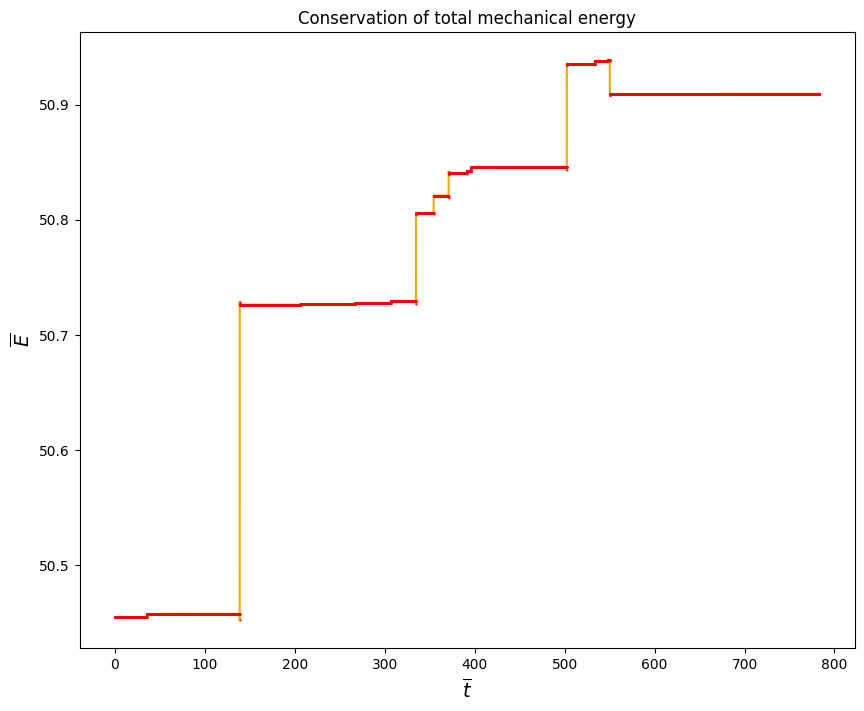

In [30]:
Em = sim.get_Energy(s)[2]

plt.figure(figsize=(10,8))
plt.title('Conservation of total mechanical energy')
plt.ylabel(r'$\overline{E}$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time,Em,'-',color='orange') ;plt.plot(time,Em,'o',color='red', ms=0.5)
plt.savefig('images/NParticlesGas/'+date+' mechanical_energy.png',dpi=350)
plt.show()

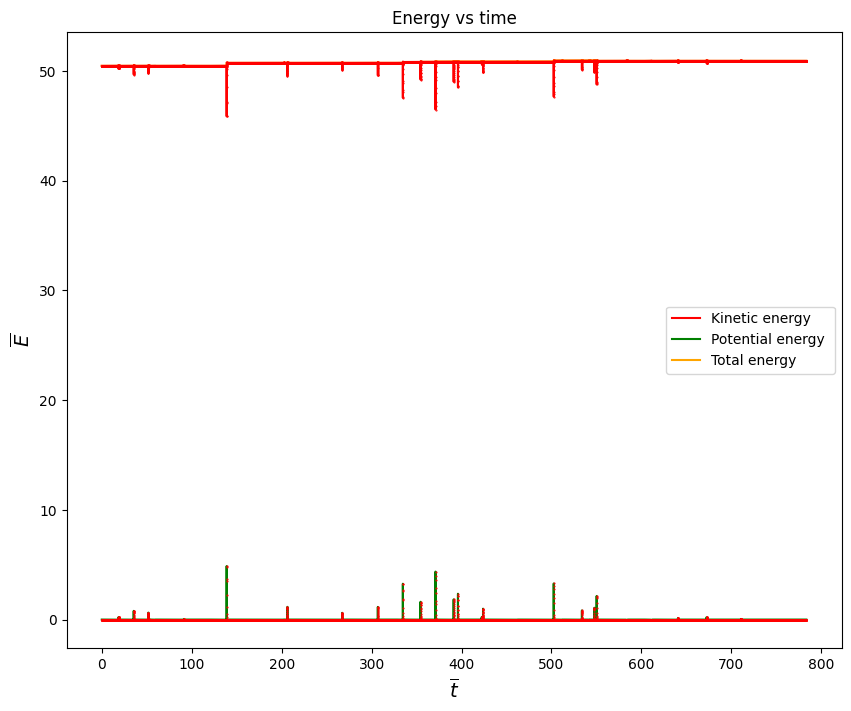

In [31]:
Ek, V, Em  = sim.get_Energy(s)

plt.figure(figsize=(10,8))
plt.title('Energy vs time')
plt.ylabel(r'$\overline{E}$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time, Ek,'-',color='red',label = 'Kinetic energy') ;plt.plot(time, Ek,'o',color='red', ms=0.5)
plt.plot(time, V,'-',color='green',label = 'Potential energy ') ;plt.plot(time, V,'o',color='red', ms=0.5)
plt.plot(time, Em,'-',color='orange',label = 'Total energy') ;plt.plot(time, Em,'o',color='red', ms=0.5)
plt.legend()
plt.savefig('images/NParticlesGas/'+date+' energy.png',dpi=350)
plt.show()

As we know the temperature of an ideal gas is given in terms of the average kinetic energy of the particles $\left<K\right>$ as
$$T = \frac{2}{3 k_B} \left<K\right>\,,$$
where $k_B$ is the Boltzman's constant. We define a dimensionless temperature
$$ \overline{T} = \frac{k_B}{24\epsilon} T = \frac{2}{3} \left<\overline{K}\right> \,.$$
In this equations we have by definition $\left<\overline{K}\right> = \frac{1}{N_p} \sum\limits_{j=1}^{N_p}\frac{1}{2} \overline{v}_i^2 $, where $N_p$ is the number of particles.

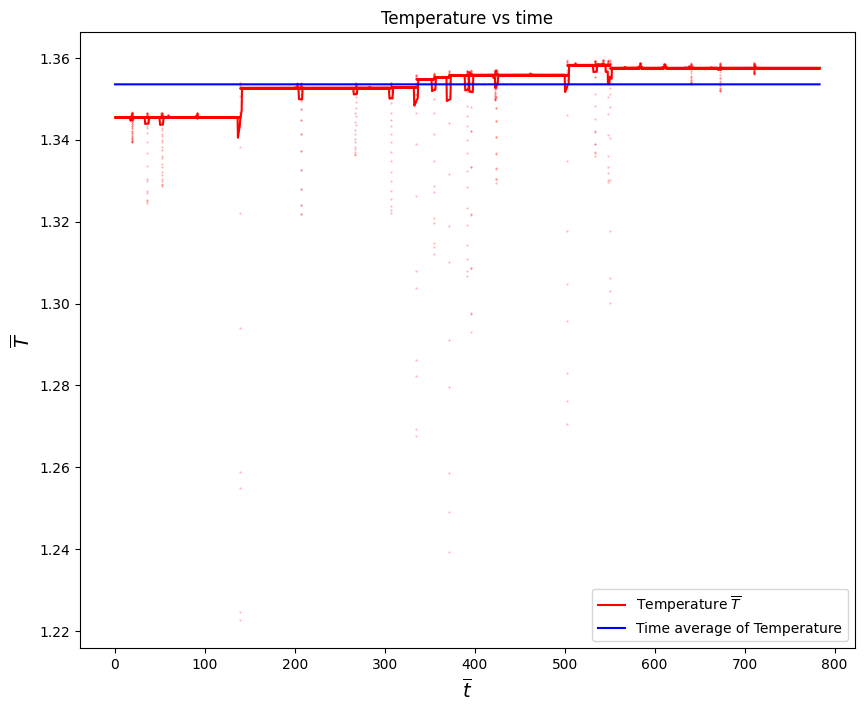

In [32]:
Ek, V, Em  = sim.get_Energy(s)
T = Ek*2/(3*self1.Np)
Tmean = np.mean(T)*np.ones(len(Ek))
#Em_mean = np.mean(Em*2/(3*self1.Np))*np.ones(len(Em))

time1, T1 = moving_mean(time,T,w=100)
plt.figure(figsize=(10,8))
plt.title('Temperature vs time')
plt.ylabel(r'$\overline{T}$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time1, T1,'-',color='red',label = r'Temperature $\overline{T}$') ;plt.plot(time, T,'o',color='red',alpha=0.3, ms=0.5)
plt.plot(time, Tmean,'-',color='blue',label = r'Time average of Temperature')
#plt.plot(time, Em_mean,'-',color='cyan',label = r'Time average of $\frac{2}{3N_p}\overline{E}$')
plt.legend()
plt.savefig('images/NParticlesGas/'+date+' temperature.png',dpi=350)
plt.show()

In [123]:
%matplotlib auto
%matplotlib auto

Using matplotlib backend: TkAgg
Using matplotlib backend: TkAgg


In [33]:
#animate_path(self1,s,duration=40,kind=0,save=False,name=date+'test.mp4',verbose=True,plot_params=['-b','or',1,5,0.3],amp=3)
#plt.show()

The pressure of one particle over one wall is typically consider as
$$ P_i = \frac{m v_{\perp}^2}{A L}\,, $$
where $v_{\perp}$ is the normal component of the velocity respecting to the wall, $m$ is the mass of the particle, $A$ is the area of the wall, and $L$ is the length of the container, which is the distance between the wall and its counterpart. The total pressure on the wall is then
$$ P = \sum\limits_{i=1}^{N_p}\frac{m v_{\perp}^2}{A L} = \frac{N_p m \left<v_{\perp}^2\right>}{A L }\,,$$
where $\left<v_{\perp}^2\right> = \frac{1}{3}\left<v^2\right>$ is the average velocity of the particles. Here we define a dimensionless pressure times unit depth as 
$$ \overline{P}  = \frac{d\sigma^2}{24 \epsilon} P\,,$$
where $d$ is the depth of the box and $A=d\ell$. Then, the dimensionless pressure can be written as
$$ \overline{P} = \frac{2}{3} \frac{N_p \left< \overline{K} \right>}{\overline{\ell} \overline{L} } \,. $$
In the code we use the definition  $P_i\,d = \frac{1}{\ell}\frac{\Delta p}{\Delta t}\,,$ where $\ell$ is the height of the wall. The area being $A=\ell d$.

In [6]:
def get_Pressures(s,time,box,dt):
    """ 
    @params:
        s : list of arrays. It is the data of position and velocity gotten from LJGas.simulate()
        time : array-like. It is the dimensionless time assigned for each iteration.
        box : list. It contains the dimensions of the box that confines the gas.
        dt : float. It is the amplitud of the interval used for calculating the mean force 
            assigned to the colision between the particles and the walls. Choose it carefully.

    @exits:
        time_P : array-like. It is the time associated to each component of the pressures arrays.
        P_top : array-like. Pressure of the top wall.
        P_bottom : array-like. Pressure of the bottom wall.
        P_right : array-like. Pressure of the right wall.
        P_left : array-like. Pressure of the left wall.

    @example:
        >> ...
        >> dt = 5*h
        >> time_P, P_top, P_bottom, P_right, P_left = get_Pressures(s,time,box,dt)
    """

    # Condition for bouncing in any of the walls
    LVX = s[2]; LVY = s[3]
    ii = LVX[:-1]+LVX[1:]==0; jj = LVY[:-1]+LVY[1:]==0

    # Get change in momentum
    aux = LVX.shape[0]-1
    p_right = np.zeros(aux); p_left = np.zeros(aux); p_top = np.zeros(aux); p_bottom = np.zeros(aux)

    for i in range(len(ii)):
        A = LVX[i][ii[i]]; B = LVY[i][jj[i]]
        p_right[i] = 2*np.sum(A[A>=0])
        p_left[i] = 2*np.sum(A[A<0])
        p_top[i] = 2*np.sum(B[B>=0])
        p_bottom[i] = 2*np.sum(B[B<0])

    # Get Pressure per unit deep in each wall
    Nk = int(time[-1]/dt)
    P_right = np.zeros(Nk); P_left = np.zeros(Nk); P_top = np.zeros(Nk); P_bottom = np.zeros(Nk); time_P = np.arange(Nk)*dt

    time1 = time[:-1]
    for k in range(Nk):
        A = (time1>=k*dt)*(time1<(k+1)*dt)
        P_right[k] = np.sum(p_right[A])/(dt*box[1])
        P_left[k] = np.abs(np.sum(p_left[A])/(dt*box[1]))
        P_top[k] = np.sum(p_top[A])/(dt*box[0])
        P_bottom[k] = np.abs(np.sum(p_bottom[A])/(dt*box[0]))
    return time_P, P_top, P_bottom, P_right, P_left

In [35]:
%matplotlib inline

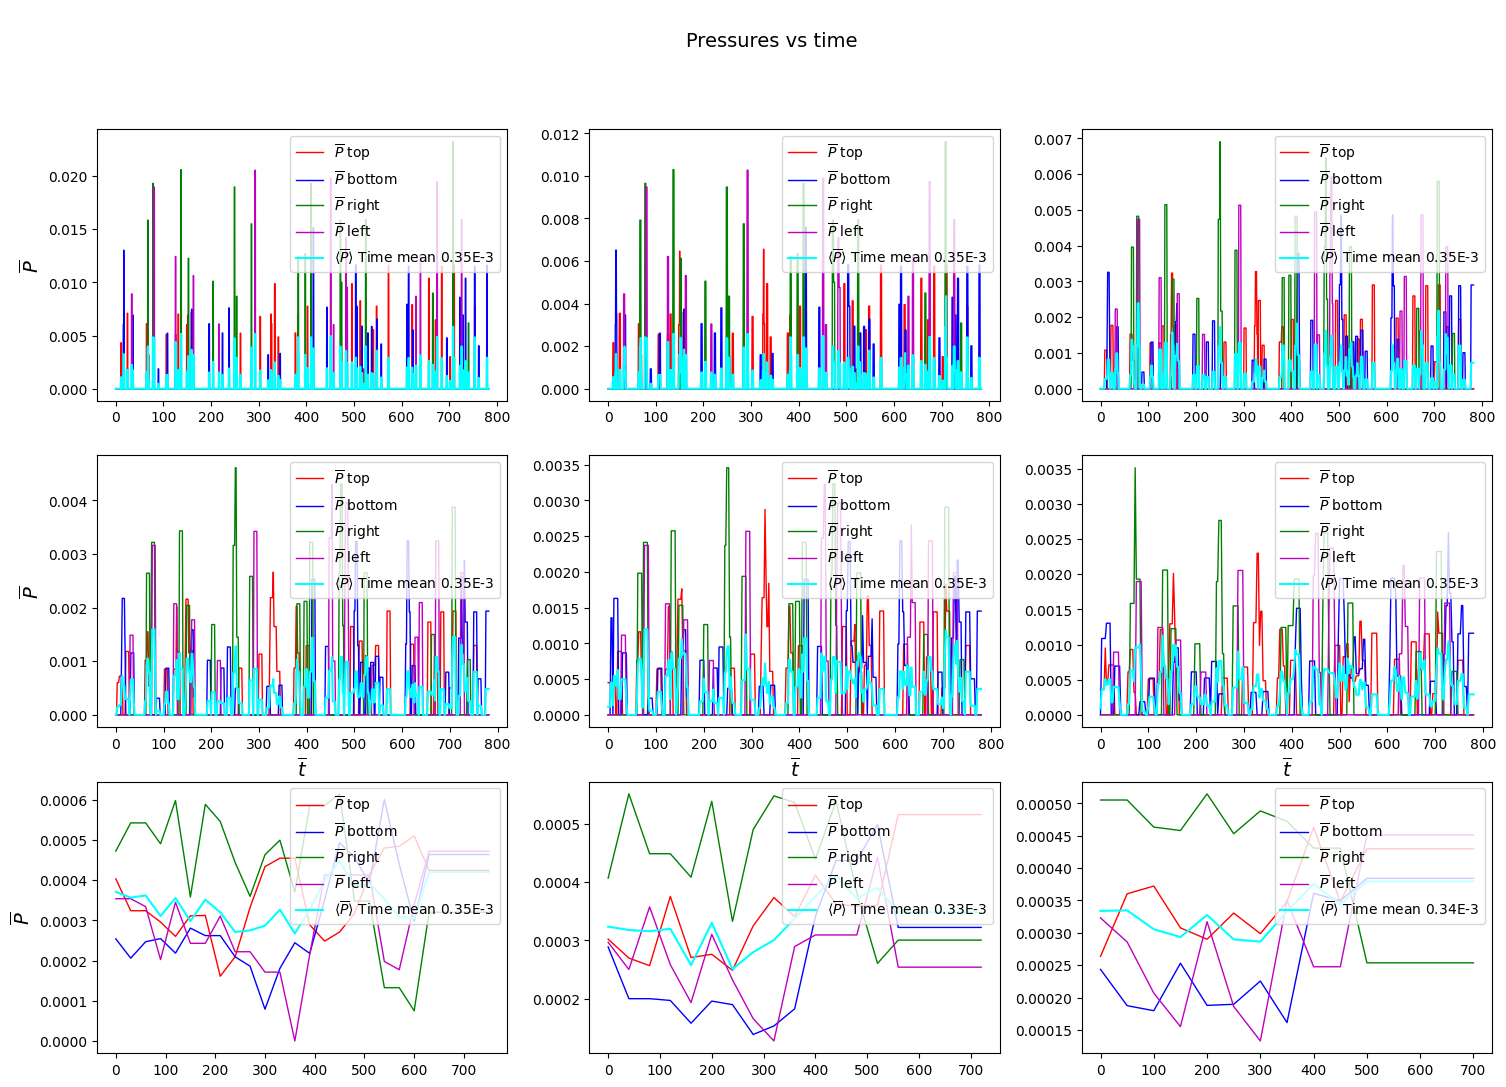

In [36]:
#Ldt = [5*h, 10*h, 20*h, 30*h, 40*h, 50*h, 60*h, 80*h, 100*h]
Ldt = [5*h, 10*h, 20*h, 30*h, 40*h, 50*h, 600*h, 800*h, 1000*h]

fig = plt.figure(figsize=(18,12))
fig.suptitle('\nPressures vs time', fontsize=14)
for i in range(len(Ldt)):
    plt.subplot(3,3,i+1)
    time_P, P_top, P_bottom, P_right, P_left = get_Pressures(s,time,box,Ldt[i])
    w = 5; kind = 0
    time_P1, P_top1 = moving_mean(time_P,P_top,w,kind)
    time_P1, P_bottom1 = moving_mean(time_P,P_bottom,w,kind)
    time_P1, P_right1 = moving_mean(time_P,P_right,w,kind)
    time_P1, P_left1 = moving_mean(time_P,P_left,w,kind)
    P_mean1 = (P_top1+P_bottom1+P_right1+P_left1)/4

    if i in [0,3,6] : plt.ylabel(r'$\overline{P}$',fontsize=14)
    if i in [3,4,5] : plt.xlabel(r'$\overline{t}$',fontsize=14)
    plt.plot(time_P1,P_top1,'-r',label=r'$\overline{P}$ top',lw=1)        #;plt.plot(time_P, P_top,'o',color='red',alpha=0.5, ms=1.5)
    plt.plot(time_P1,P_bottom1,'-b',label=r'$\overline{P}$ bottom',lw=1)  #;plt.plot(time_P, P_bottom,'o',color='blue',alpha=0.5, ms=1.5)
    plt.plot(time_P1,P_right1,'-g',label=r'$\overline{P}$ right',lw=1)    #;plt.plot(time_P, P_right,'o',color='green',alpha=0.5, ms=1.5)
    plt.plot(time_P1,P_left1,'-m',label=r'$\overline{P}$ left',lw=1)      #;plt.plot(time_P, P_left,'o',color='magenta',alpha=0.5, ms=1.5)
    plt.plot(time_P1,P_mean1,'-',color='cyan',label=r'$\left< \overline{P} \right>$ Time mean '+f'{np.round(np.mean(P_mean1)*10**3,2)}E-3')
    plt.legend(loc='upper right')
plt.savefig('images/NparticlesGas/'+date+' pressures.png',dpi=300)
plt.show()

In [37]:
Kmean = 3/2*np.mean(T)
P_predicted = 2/3*Np*Kmean/(box[0]*box[1])

print(f'P predicted: {np.round(np.mean(P_predicted)*10**3,3)}E-3')

P predicted: 0.423E-3


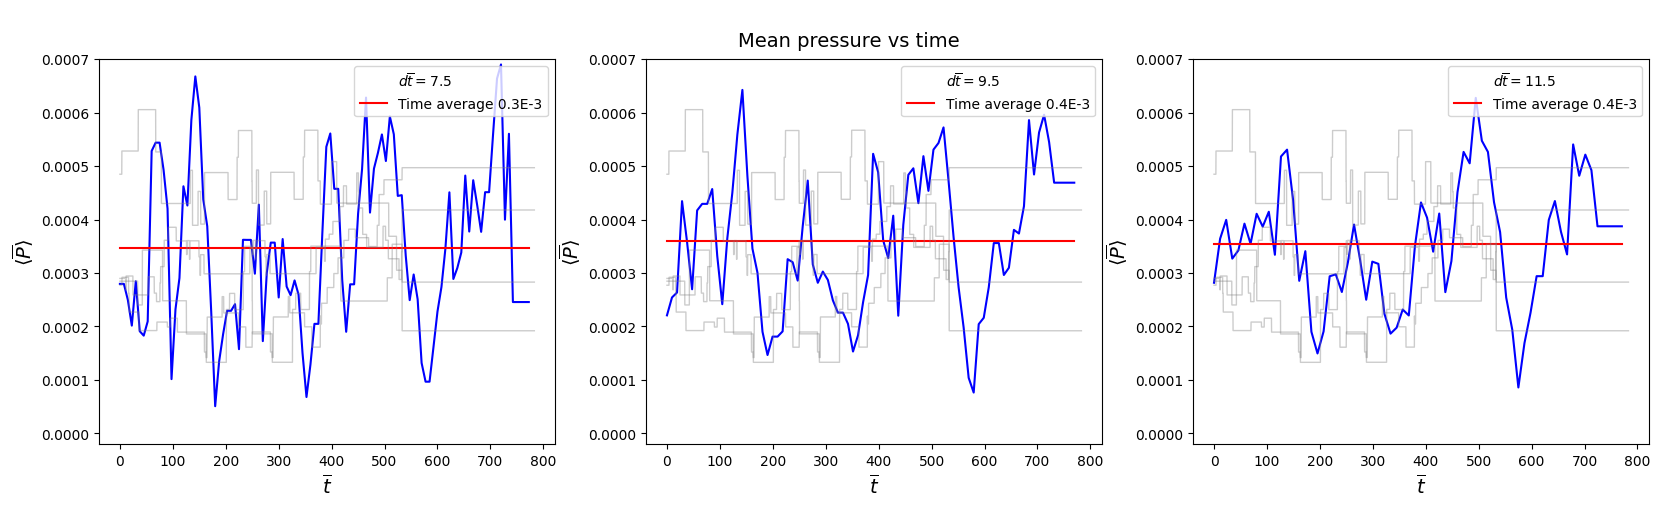

In [38]:
#Ldt = [60*h, 80*h, 100*h]
Ldt = [150*h, 190*h, 230*h]

fig = plt.figure(figsize=(20,5))
fig.suptitle('\nMean pressure vs time\n', fontsize=14)
for i in range(len(Ldt)):
    plt.subplot(1,3,i+1)
    time_P, P_top, P_bottom, P_right, P_left = get_Pressures(s,time,box,Ldt[i])
    w = 5; kind = 0
    time_P1, P_top1 = moving_mean(time_P,P_top,w,kind)
    time_P1, P_bottom1 = moving_mean(time_P,P_bottom,w,kind)
    time_P1, P_right1 = moving_mean(time_P,P_right,w,kind)
    time_P1, P_left1 = moving_mean(time_P,P_left,w,kind)
    P_mean1 = (P_top1+P_bottom1+P_right1+P_left1)/4
    P_mean2 = np.mean(P_mean1)*np.ones(len(time_P1))

    plt.ylabel(r'$\left< \overline{P} \right>$',fontsize=14)
    plt.xlabel(r'$\overline{t}$',fontsize=14)
    plt.plot(time_P1,P_mean1,'-',color='blue')
    plt.plot(0,0,'o',ms=0,label=r'$d\overline{t} = $'+f'{np.round(Ldt[i],2)}')
    plt.plot(time_P1,P_mean2,'-',color='red',label=r'Time average '+f'{np.round(np.mean(P_mean1)*10**3,1)}E-3')

    time_P, P_top, P_bottom, P_right, P_left = get_Pressures(s,time,box,5*h)
    w = 1000; kind = 0; lw=1; alpha=0.4
    time_P1, P_top1 = moving_mean(time_P,P_top,w,kind)
    time_P1, P_bottom1 = moving_mean(time_P,P_bottom,w,kind)
    time_P1, P_right1 = moving_mean(time_P,P_right,w,kind)
    time_P1, P_left1 = moving_mean(time_P,P_left,w,kind)
    P_mean1 = (P_top1+P_bottom1+P_right1+P_left1)/4
    plt.plot(time_P1,P_top1,'-',color='gray',lw=lw,alpha=alpha)
    plt.plot(time_P1,P_bottom1,'-',color='gray',lw=lw,alpha=alpha)
    plt.plot(time_P1,P_right1,'-',color='gray',lw=lw,alpha=alpha)
    plt.plot(time_P1,P_left1,'-',color='gray',lw=lw,alpha=alpha)
    plt.ylim(-0.00002,0.0007)
    plt.legend(loc='upper right')
plt.savefig('images/NparticlesGas/'+date+' pressures1.png',dpi=300)
plt.show()

In [39]:
print(f'Delta t: {2*box[0]/np.max(np.abs(Vx0))}')
print(f'Delta t: {2*box[0]/np.max(np.abs(Vx0))}')

Delta t: 403.65134060095335
Delta t: 403.65134060095335


# **4. Special simulations**

## **A. Particles in a rectangular grid as initial condition**

In [16]:
date = 'sim4_'
#date = datetime.now().strftime("%m-%d_%H-%M-%S")

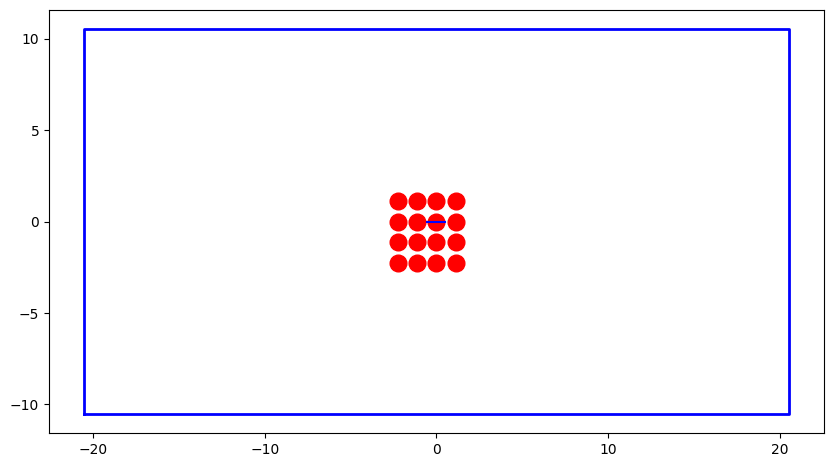

In [ ]:
%matplotlib inline

# Choose parameters 
h = 0.05; N = 8000; R0 = 1.05; h0 = 0.01; box=[40,20]

# Set intial conditions
side = 1.12256; NL = 8  # Hexágono estable
# side = 1.12256; NL = 10 # meta-estable irregular
# side = 1.08; NL=8       # Estable cuadrada -> estable cuasirectángular 
side = 1.12256; NL = 4  # Cubo estable 3x3 al inicio

pos = [-NL*side/2,-NL*side/2]
X_ = np.arange(pos[0],pos[0]+NL*side,side)
Y_ = np.arange(pos[1],pos[1]+NL*side,side)
X0, Y0 = np.meshgrid(X_,Y_)
# tam = len(X_)*len(Y_)
tam = NL**2
X0 = X0.reshape((tam,))
Y0 = Y0.reshape((tam,))
Vx0 = np.zeros(tam)
Vy0 = np.zeros(tam)
Np = len(X0)

# Only for the second simulations!
#sim = LJGas(h,N,Np,R0,h0,box,verbose=False)
#s = sim.simulate([X0,Y0,Vx0,Vy0])
#Xf = s[0][-1,:]; Yf = s[1][-1,:]; Vxf = s[2][-1,:]; Vyf = s[3][-1,:]
#X0 = Xf; Y0 = Yf; Vx0 = Vxf; Vy0 = Vyf

# To concatenate another particle
#X0 = np.concatenate([X0,np.array([10.0])])
#Y0 = np.concatenate([Y0,np.array([0.0])])
#Vx0 = np.concatenate([Vx0,np.array([-3.5])])
#Vy0 = np.concatenate([Vy0,np.array([0.0])])
#Np += 1

height = 10*box[1]/box[0]+0.5
plt.figure(figsize=(10,height))
plt.plot(X0,Y0,'or',ms=12)
b0 = box[0]/2+R0/2; b1 = box[1]/2+R0/2
plt.plot([-b0,b0,b0,-b0,-b0],[-b1,-b1,b1,b1,-b1],'-b',lw=2)
plt.plot([-R0/2,R0/2],[0,0],'-b')
plt.show()

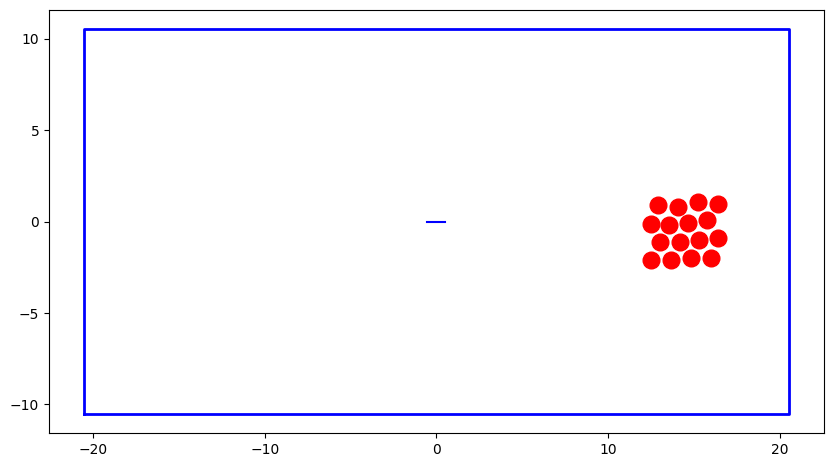

In [29]:
%matplotlib inline
# Only for the second simulations!

# Run 1st simulation
side = 1.12256; NL = 4
pos = [-NL*side/2,-NL*side/2]
X_ = np.arange(pos[0],pos[0]+NL*side,side); Y_ = np.arange(pos[1],pos[1]+NL*side,side); X0, Y0 = np.meshgrid(X_,Y_)
tam = NL**2; X0 = X0.reshape((tam,)); Y0 = Y0.reshape((tam,)); Vx0 = np.zeros(tam); Vy0 = np.zeros(tam)
Np = len(X0)
sim = LJGas(h,N,Np,R0,h0,box,verbose=False)
s = sim.simulate([X0,Y0,Vx0,Vy0])
Xf = s[0][-1,:]; Yf = s[1][-1,:]; Vxf = s[2][-1,:]; Vyf = s[3][-1,:]

# Run second simulation

# 1 Colissions. It requieres use of side = 1.12256; NL = 4
#X0 = np.concatenate([Xf+5,Xf-5])
#Y0 = np.concatenate([Yf,Yf])
#Vx0 = np.concatenate([Vxf*0-0.1,Vxf*0+0.1])
#Vy0 = np.concatenate([Vyf,Vyf])
#Np = len(X0)

# 2 Rigid rotation. It requieres use of side = 1.12256; NL = 4
#omega = 0.2
#X0 = Xf
#Y0 = Yf
#Xcm = np.sum(X0)/len(X0)
#Ycm = np.sum(Y0)/len(Y0)
#R = np.sqrt((X0-Xcm)**2 + (Y0-Ycm)**2)
#Theta = np.arctan2(Y0-Ycm,X0-Xcm)
#Vx0 = -omega*R*np.sin(Theta)
#Vy0 = omega*R*np.cos(Theta)
#Np = len(X0)

# 3 Bouncing over the walls. It requieres use of side = 1.12256; NL = 4
X0 = Xf+15
Y0 = Yf
Vx0 = Vxf*0 + 0.1
Vy0 = Vyf*0 + 0.1

height = 10*box[1]/box[0]+0.5
plt.figure(figsize=(10,height))
plt.plot(X0,Y0,'or',ms=12)
#plt.plot(Xcm,Ycm,'og',ms=6) #Center of mass
b0 = box[0]/2+R0/2; b1 = box[1]/2+R0/2
plt.plot([-b0,b0,b0,-b0,-b0],[-b1,-b1,b1,b1,-b1],'-b',lw=2)
plt.plot([-R0/2,R0/2],[0,0],'-b')
plt.show()

In [30]:
sim = LJGas(h,N,Np,R0,h0,box,verbose=False)
s = sim.simulate([X0,Y0,Vx0,Vy0])

self1 = sim.get_self()
Lh = self1.Lh
time = np.zeros(N+1)
for i in range(N):
    time[i+1] = time[i]+Lh[i]

In [165]:
Xf = s[0][-1,:]
Yf = s[1][-1,:]
Vxf = s[2][-1,:]
Vyf = s[3][-1,:]

In [31]:
%matplotlib auto
%matplotlib auto

Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg


In [32]:
animate_path(self1,s,duration=40,kind=0,save=False,name=date+'NonRigidRotation.mp4',verbose=True,plot_params=['-b','or',1,5,0.3],amp=3,interval=10)

**Observaciones**
`box=[40,20]`
* Para `side = 1.12256` (posición de equilibrio) y `NL=8` el sistema se reorganiza en una configuración estable hexágonal!
    * Al cambiar a `NL=10` ya se obtiene una configuración meta-estable irregular.
    * Al cambiar `side = 1.08` se obtiene una configuración estable cuadrada al incio pero luego trancisiona a una configuaración estable cuasirectángular, con distancias entre partículas de `1.12` approximadamente.
    * Para `side = 1.08` y `NL=10` el sistema es meta-estable al inicio con forma tipo estrella y luego transiciona a un estado estable, con distancias entre partículas apropiadas.
* La configuración de 4 partículas es estable porque las fuerzas a cada partícula adyacente es cero y la fuerza de atracción en la diagonal es despreciable.
* Para rotación rigida respecto al centro de masa con `NL=4`, `slide=1.12256` y `omega=0.2` se obtiene rotación rigida meta-estable al incio, pero el cristal se deshace debido a la apariencia cuasi-rectángular incial.
    * Cuando las posiciones inciales no tienen simetría rotacional, lo más probable es que el cristal se desaga debido a que las partes más alejadas rotan más rápido y tienden a alejarse de las demás particulas, evitando la interacción inter-partícula.
    * Se obtuvo un rebote no rígido en las esquinas.
    * Al cambiar a `omega=0.1` se corrige el efecto de despedazado y se obtiene una rotación rígida estable!
    * Al usar `omega=2` el sistema rápidamente se deshace enviando las partículas en todas direcciones de manera casi radial. (Podrían haber errores de código para este valor tan grande)
* Para rebote en las paredes se obtiene un rebote rígido si `Nl=4`, `slide=1.12256`, `Vx0=0.1` y `Vy0=0.1`

In [112]:
%matplotlib inline

In [231]:
Ek, V, Em  = sim.get_Energy(s)
T = Ek*2/(3*self1.Np)
Tmean = np.mean(T)*np.ones(len(Ek))
#Em_mean = np.mean(Em*2/(3*self1.Np))*np.ones(len(Em))

time1, T1 = moving_mean(time,T,w=100)
plt.figure(figsize=(10,8))
plt.title('Temperature vs time')
plt.ylabel(r'$\overline{T}$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time1, T1,'-',color='red',label = r'Temperature $\overline{T}$') ;plt.plot(time, T,'o',color='red',alpha=0.3, ms=0.5)
plt.plot(time, Tmean,'-',color='blue',label = r'Time average of Temperature')
#plt.plot(time, Em_mean,'-',color='cyan',label = r'Time average of $\frac{2}{3N_p}\overline{E}$')
plt.legend()
plt.savefig('images/NParticlesGas/temperature.png',dpi=350)
plt.show()

In [232]:
print(f'{np.round(Tmean[0]*1000,2)}e-3')

24.81e-3


In [233]:
Ek, V, Em  = sim.get_Energy(s)

plt.figure(figsize=(10,8))
plt.title('Energy vs time')
plt.ylabel(r'$\overline{E}$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time, Ek,'-',color='red',label = 'Kinetic energy') ;#plt.plot(time, Ek,'o',color='red', ms=0.5)
plt.plot(time, V-V[0],'-',color='green',label = 'Potential energy') ;#plt.plot(time, V,'o',color='red', ms=0.5)
plt.plot(time, Em-V[0],'-',color='orange',label = 'Total energy') ;#plt.plot(time, Em,'o',color='red', ms=0.5)
plt.legend()
plt.savefig('images/2ParticlesGas/energy_vs_time.png',dpi=350)
#plt.ylim(-0.2,4.2)
plt.show()

In [ ]:
Ldt = [5*h, 10*h, 20*h, 30*h, 40*h, 50*h, 60*h, 80*h, 100*h]

fig = plt.figure(figsize=(18,12))
fig.suptitle('\nPressures vs time', fontsize=14)
for i in range(len(Ldt)):
    plt.subplot(3,3,i+1)
    time_P, P_top, P_bottom, P_right, P_left = get_Pressures(s,time,box,Ldt[i])
    w = 5; kind = 0
    time_P1, P_top1 = moving_mean(time_P,P_top,w,kind)
    time_P1, P_bottom1 = moving_mean(time_P,P_bottom,w,kind)
    time_P1, P_right1 = moving_mean(time_P,P_right,w,kind)
    time_P1, P_left1 = moving_mean(time_P,P_left,w,kind)
    P_mean1 = (P_top1+P_bottom1+P_right1+P_left1)/4

    if i in [0,3,6] : plt.ylabel(r'$\overline{P}$',fontsize=14)
    if i in [3,4,5] : plt.xlabel(r'$\overline{t}$',fontsize=14)
    plt.plot(time_P1,P_top1,'-r',label=r'$\overline{P}$ top',lw=1)        #;plt.plot(time_P, P_top,'o',color='red',alpha=0.5, ms=1.5)
    plt.plot(time_P1,P_bottom1,'-b',label=r'$\overline{P}$ bottom',lw=1)  #;plt.plot(time_P, P_bottom,'o',color='blue',alpha=0.5, ms=1.5)
    plt.plot(time_P1,P_right1,'-g',label=r'$\overline{P}$ right',lw=1)    #;plt.plot(time_P, P_right,'o',color='green',alpha=0.5, ms=1.5)
    plt.plot(time_P1,P_left1,'-m',label=r'$\overline{P}$ left',lw=1)      #;plt.plot(time_P, P_left,'o',color='magenta',alpha=0.5, ms=1.5)
    plt.plot(time_P1,P_mean1,'-',color='cyan',label=r'$\left< \overline{P} \right>$ Time mean '+f'{np.round(np.mean(P_mean1)*10**3,1)}E-3')
    plt.legend(loc='upper right')
plt.savefig('images/NparticlesGas/pressures.png',dpi=300)
plt.show()

## **B. Particles in a hexagonal grid as initial positions**

In [33]:
date = 'sim4B_'
#date = datetime.now().strftime("%m-%d_%H-%M-%S")

In [127]:
2**(1/6)

1.122462048309373

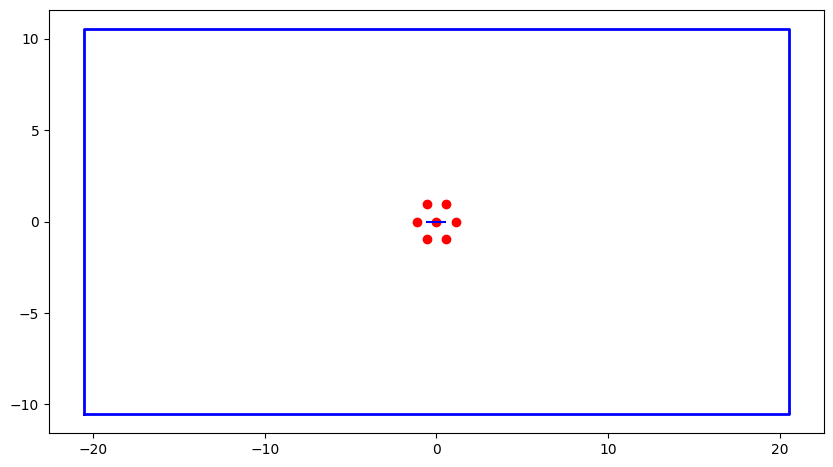

In [138]:
%matplotlib inline

# Choose parameters 
#a: number of atoms over the middle horizontal line, b: number of rows of atoms
h = 0.05; N = 8000; R0 = 1.05; h0 = 0.01; box=[40,20]
#side = 1.12256; a = 15; b = 15       
side = 2**(1/6); a =3; b = 3

# Set intial conditions
a1 = side*np.array([1,0])
a2 = side*np.array([np.cos(2*np.pi/3),np.sin(2*np.pi/3)])
X0 = []; Y0 = []
mL = np.arange(0,b,1) - b//2
base = np.arange(0,a,1) - a//2
nL = []
for i in range(len(mL)):
    if mL[i]<0: nL.append(base[0:mL[i]])
    elif mL[i]==0: nL.append(base)
    else: nL.append(base[mL[i]:])

for i in range(len(mL)):
    for n in nL[i]:
        R = mL[i]*a2+n*a1
        X0.append(R[0])
        Y0.append(R[1])
X0 = np.array(X0)
Y0 = np.array(Y0)
Np = len(X0)
Vx0 = np.zeros(Np)
Vy0 = np.zeros(Np)

# Only for the second simulations!
#sim = LJGas(h,N,Np,R0,h0,box,verbose=False)
#s = sim.simulate([X0,Y0,Vx0,Vy0])
#Xf = s[0][-1,:]; Yf = s[1][-1,:]; Vxf = s[2][-1,:]; Vyf = s[3][-1,:]
#X0 = Xf; Y0 = Yf; Vx0 = Vxf; Vy0 = Vyf

height = 10*box[1]/box[0]+0.5
plt.figure(figsize=(10,height))
plt.plot(X0,Y0,'or',ms=6)
b0 = box[0]/2+R0/2; b1 = box[1]/2+R0/2
plt.plot([-b0,b0,b0,-b0,-b0],[-b1,-b1,b1,b1,-b1],'-b',lw=2)
plt.plot([-R0/2,R0/2],[0,0],'-b')
plt.show()

In [139]:
N = 8000//3
sim = LJGas(h,N,Np,R0,h0,box,verbose=False)
s = sim.simulate([X0,Y0,Vx0,Vy0])

self1 = sim.get_self()
Lh = self1.Lh
time = np.zeros(N+1)
for i in range(N):
    time[i+1] = time[i]+Lh[i]

In [71]:
Xf = s[0][-1,:]
Yf = s[1][-1,:]
Vxf = s[2][-1,:]
Vyf = s[3][-1,:]

In [140]:
%matplotlib auto
%matplotlib auto

Using matplotlib backend: QtAgg
Using matplotlib backend: QtAgg


In [141]:
animate_path(self1,s,duration=40,kind=0,save=False,name=date+'NonRigidRotation.mp4',verbose=True,plot_params=['-b','or',1,5,0.3],amp=3,interval=10)

In [74]:
%matplotlib inline

**Observaciones**
`box=[40,20]`
* Para `side = 1.12256` (posición de equilibrio), `a=5`, `b=5`, `Vx0=0` y `Vy=-0.1` se obtiene una colisión inelástica en la pared inferior. 
    * El hecho de que sea inelástica puede deberse a que el cristal se deforma al colisionar con la pared y no regresa a su configuración inicial pues las particulas qudan vibrando más que al incio (modos traslacionales a modos vibracionales -> adquieren temperatura vibracional)
* Al cambiar `Vy0=-0.2` se obtiene un rebote no rígido seguido de una configuración meta-estable con adquisición de modos vibracionales.
* Para el observador comóvil con el sistema no hay conservación de energía debido a que haría falta considerar el potencial y energía cinética de las paredes de la caja.
* Al cambiar `Vy0=-0.4` el sistema se deshace al colisionar con la pared inferior.
* Al cambiar `Vy0=-0.4`, `a=9` y `b=9`  el sistema se parte en dos mitades.

In [132]:
Ek, V, Em  = sim.get_Energy(s)
T = Ek*2/(3*self1.Np) #Temperatura para un gas con partículas que se mueven casi libremente

Ek = np.zeros(N+1)
for i in range(N+1): #Recorre cada iteración i de la simulación
    Vx = s[2][i,:]
    Vy = s[3][i,:]
    Vxcm = np.sum(Vx)/Np
    Vycm = np.sum(Vy)/Np
    Eki = 1/2*((Vx-Vxcm)**2+(Vy-Vycm)**2)
    Ek[i] = np.sum(Eki) #Energia cinética respecto a un observador comóvil con el centro de masa
T = Ek*2/(3*Np) #Temperatura respectoa al observador comóvil con el centro de masa (Depende de los modos vibracionales principalmente)

Tmean = np.mean(T)*np.ones(len(Ek))
#Em_mean = np.mean(Em*2/(3*self1.Np))*np.ones(len(Em))

time1, T1 = moving_mean(time,T,w=100)
plt.figure(figsize=(10,8))
plt.title('Vibrational Temperature vs time')
plt.ylabel(r'$\overline{T}$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time1, T1,'-',color='red',label = r'Vibrational Temperature $\overline{T}$') ;plt.plot(time, T,'o',color='red',alpha=0.3, ms=0.5)
plt.plot(time, Tmean,'-',color='blue',label = r'Time average of Temperature')
#plt.plot(time, Em_mean,'-',color='cyan',label = r'Time average of $\frac{2}{3N_p}\overline{E}$')
plt.legend()
plt.savefig('images/NParticlesGas/temperature.png',dpi=350)
plt.show()

In [133]:
print(f'{np.round(Tmean[0]*1000,2)}e-3')

0.11e-3


In [134]:
Ek, V, Em  = sim.get_Energy(s)

plt.figure(figsize=(10,8))
plt.title('Energy vs time')
plt.ylabel(r'$\overline{E}$',fontsize=14)
plt.xlabel(r'$\overline{t}$',fontsize=14)
plt.plot(time, Ek,'-',color='red',label = 'Kinetic energy') ;#plt.plot(time, Ek,'o',color='red', ms=0.5)
plt.plot(time, V-V[0],'-',color='green',label = 'Potential energy') ;#plt.plot(time, V,'o',color='red', ms=0.5)
plt.plot(time, Em-V[0],'-',color='orange',label = 'Total energy') ;#plt.plot(time, Em,'o',color='red', ms=0.5)
plt.legend()
plt.savefig('images/2ParticlesGas/energy_vs_time.png',dpi=350)
#plt.ylim(-0.2,4.2)
plt.show()

In [135]:
print(f'{np.round(V[0]*1,2)}e0')


-21.36e0


# **Anexos**

In [ ]:
# Partition an array

X = np.arange(1,101)
LC = [[9,19],[39,69]]
slice_step=2

i0 = LC[0][0]
Ls = [X[:i0]]
for k in range(len(LC)-1):
    i,j = LC[k]
    i1,j1 = LC[k+1]
    Ls.append(X[i:j:slice_step])
    Ls.append(X[j:i1])
Ls.append(X[i1:j1:slice_step])
Ls.append(X[j1:])
X1 = np.concatenate(Ls)
X1

In [ ]:
X = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
t = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
t1, Xmean = moving_mean(t,X,10,0)
Xmean